In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
from shapely.geometry import LineString, Point
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import hvplot.pandas
import contextily as ctx

# Visualización de la Matriz OD

Vamos a visualizar la martiz que obtuvimos en el notebook `01-matrizOD`. Lo que vamos a hacer es obtener los centroides de cada una de las zonas y crear líneas que unan los centroides de acuerdo a los resultados de la matriz. Los pesos de las líneas serán la cantidad de viajes promedio.

## Centroides de las zonas de análisis


Obtenemos los centroides

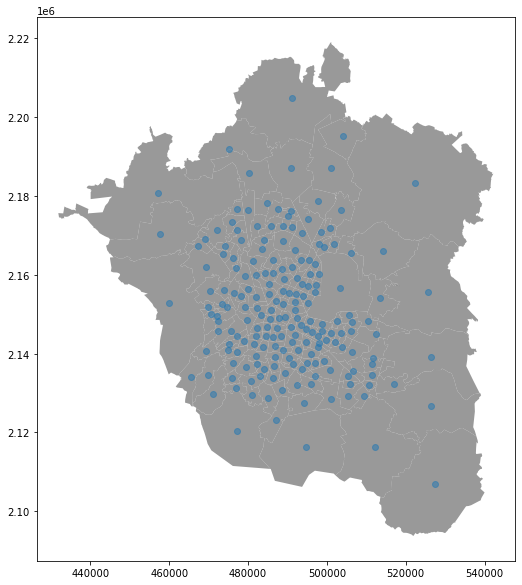

In [2]:
zonas = gpd.read_file("../data/shapes/DistritosEODHogaresZMVM2017.shp")
centros = zonas.copy()
centros['geometry'] = centros['geometry'].centroid
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
centros.plot(ax=ax, alpha=0.5)
plt.show()

## Unir con la matriz

Ya tenemos los centroides, ahora vamos a unirlos con la matriz OD. Necesitamos asignar un punto al distrito de origen y uno al de destino para hacer las líneas

In [3]:
matriz = pd.read_csv("../output/matriz_od_semana_2018.csv", skiprows=1, dtype={'distrito_origen':str, 'distrito_destino':str})
matriz.drop(['Unnamed: 0'], axis=1, inplace=True)
matriz

intervalo distrito_origen distrito_destino  sum       mean       std
0      02:00:00             001              001  410   7.735849  4.015120
1      02:00:00             001              002  238  17.000000  6.598368
2      02:00:00             001              003   45   1.500000  0.682288
3      02:00:00             001              004   11   1.100000  0.316228
4      02:00:00             001              005   14   1.000000  0.000000
...         ...             ...              ...  ...        ...       ...
16753  22:00:00             300              134    1   1.000000       NaN
16754  22:00:00             300              135    1   1.000000       NaN
16755  22:00:00             300              165    4   1.333333  0.577350
16756  22:00:00             300              171    1   1.000000       NaN
16757  22:00:00             300              300    6   1.000000  0.000000

[16758 rows x 6 columns]

Seleccionamos un intervalo, por ejemplo en la mañana cuando todos se están yendo a trabajar, además seleccionemos sólo los que tengan más de diez viajes en total

In [4]:
morning = matriz.loc[(matriz['intervalo'] == '06:00:00') & (matriz['sum'] > 10)].copy()
morning

intervalo distrito_origen distrito_destino  sum      mean       std
3380  06:00:00             001              001   78  2.052632  1.432204
3381  06:00:00             001              002   46  3.538462  2.436370
3382  06:00:00             001              003   13  1.181818  0.404520
3386  06:00:00             001              007   11  1.000000  0.000000
3387  06:00:00             001              008   42  1.826087  0.984063
...        ...             ...              ...  ...       ...       ...
4570  06:00:00             139              020   11  1.000000  0.000000
4582  06:00:00             139              034   20  1.333333  0.723747
4587  06:00:00             139              049   21  1.500000  0.854850
4598  06:00:00             139              115   12  1.090909  0.301511
4612  06:00:00             141              142   13  1.444444  0.726483

[126 rows x 6 columns]

Para esta visualización, tomemos sólo los viajes entre zonas de análisis, es decir, aquellos en los que el origen y el destino sean diferentes

In [5]:
morning =  morning.loc[morning['distrito_origen'] != morning['distrito_destino']]
morning

intervalo distrito_origen distrito_destino  sum      mean       std
3381  06:00:00             001              002   46  3.538462  2.436370
3382  06:00:00             001              003   13  1.181818  0.404520
3386  06:00:00             001              007   11  1.000000  0.000000
3387  06:00:00             001              008   42  1.826087  0.984063
3394  06:00:00             001              015   18  1.384615  0.650444
...        ...             ...              ...  ...       ...       ...
4570  06:00:00             139              020   11  1.000000  0.000000
4582  06:00:00             139              034   20  1.333333  0.723747
4587  06:00:00             139              049   21  1.500000  0.854850
4598  06:00:00             139              115   12  1.090909  0.301511
4612  06:00:00             141              142   13  1.444444  0.726483

[113 rows x 6 columns]

Ahora vamos a unir dos veces con los centroides, una usando `distrito_origen` y otra usando `distrito_destino`

In [6]:
morning = (morning.merge(centros, left_on='distrito_origen', right_on='Distrito')
             .drop('Descripcio', axis=1)
             .rename({'geometry':'point_origen'}, axis=1)
             .merge(centros, left_on='distrito_destino', right_on='Distrito')
             .drop(['Descripcio', 'Distrito_y', 'Distrito_x'], axis=1)
             .rename({'geometry':'point_destino'}, axis=1)
          )
morning

intervalo distrito_origen distrito_destino  sum      mean       std  \
0    06:00:00             001              002   46  3.538462  2.436370   
1    06:00:00             008              002   18  2.250000  1.164965   
2    06:00:00             015              002   40  2.857143  2.032700   
3    06:00:00             049              002   31  2.214286  1.188313   
4    06:00:00             058              002   66  2.869565  1.659801   
..        ...             ...              ...  ...       ...       ...   
108  06:00:00             139              115   12  1.090909  0.301511   
109  06:00:00             115              024   17  1.888889  0.781736   
110  06:00:00             115              112   28  1.647059  0.861770   
111  06:00:00             117              118   11  1.100000  0.316228   
112  06:00:00             141              142   13  1.444444  0.726483   

                       point_origen                   point_destino  
0    POINT (485576.548 2148785.591)  POINT (483381.514 2149828.572)  
1    POINT (482328.362 2146361.176)  POINT (483381.514 2149828.572)  
2    POINT (481529.724 2142396.151)  POINT (483381.514 2149828.572)  
3    POINT (483999.523 2136161.217)  POINT (483381.514 2149828.572)  
4    POINT (475577.098 2145748.936)  POINT (483381.514 2149828.572)  
..                              ...                             ...  
108  POINT (489148.833 2158963.705)  POINT (481376.545 2163496.348)  
109  POINT (481376.545 2163496.348)  POINT (486212.894 2160424.851)  
110  POINT (481376.545 2163496.348)  POINT (476860.808 2161777.223)  
111  POINT (473547.314 2165206.096)  POINT (474171.174 2167233.587)  
112  POINT (488831.444 2168619.490)  POINT (488872.668 2172414.068)  

[113 rows x 8 columns]

Hacemos líneas entre origen y destino

In [7]:
morning['geometry'] = morning.apply(lambda x: LineString([x['point_origen'], x['point_destino']]), axis=1)
morning.drop(['point_origen', 'point_destino'], axis=1, inplace=True)
morning = gpd.GeoDataFrame(morning)
morning

intervalo distrito_origen distrito_destino  sum      mean       std  \
0    06:00:00             001              002   46  3.538462  2.436370   
1    06:00:00             008              002   18  2.250000  1.164965   
2    06:00:00             015              002   40  2.857143  2.032700   
3    06:00:00             049              002   31  2.214286  1.188313   
4    06:00:00             058              002   66  2.869565  1.659801   
..        ...             ...              ...  ...       ...       ...   
108  06:00:00             139              115   12  1.090909  0.301511   
109  06:00:00             115              024   17  1.888889  0.781736   
110  06:00:00             115              112   28  1.647059  0.861770   
111  06:00:00             117              118   11  1.100000  0.316228   
112  06:00:00             141              142   13  1.444444  0.726483   

                                              geometry  
0    LINESTRING (485576.548 2148785.591, 483381.514...  
1    LINESTRING (482328.362 2146361.176, 483381.514...  
2    LINESTRING (481529.724 2142396.151, 483381.514...  
3    LINESTRING (483999.523 2136161.217, 483381.514...  
4    LINESTRING (475577.098 2145748.936, 483381.514...  
..                                                 ...  
108  LINESTRING (489148.833 2158963.705, 481376.545...  
109  LINESTRING (481376.545 2163496.348, 486212.894...  
110  LINESTRING (481376.545 2163496.348, 476860.808...  
111  LINESTRING (473547.314 2165206.096, 474171.174...  
112  LINESTRING (488831.444 2168619.490, 488872.668...  

[113 rows x 7 columns]

## Mapas

### Geopandas
Primero, el más sencillo de todos, sólo con geopandas

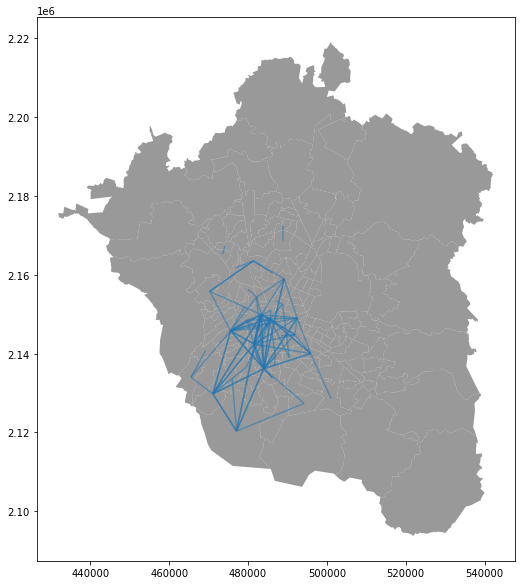

In [8]:
fig , ax = plt.subplots(1, figsize=(15,10))
zonas.plot(ax=ax, facecolor='grey', alpha=0.8)
morning.plot(ax=ax, alpha=0.5)
plt.show()

### Folium
Luego uno con folium, un poco más bonito

In [9]:
morning.crs = "EPSG:32614"
m = folium.Map()
folium.Choropleth(morning).add_to(m)
bounds = [[morning.to_crs("EPSG:4326").total_bounds[1], morning.to_crs("EPSG:4326").total_bounds[0]], 
          [morning.to_crs("EPSG:4326").total_bounds[3], morning.to_crs("EPSG:4326").total_bounds[2]]]
m.fit_bounds(bounds)
m

### Holoviews
Ahora con holoviews haciendo el ancho de las líneas proporcional al promedio de viajes

In [35]:
(morning.hvplot.paths(title='Flujos entre Distritos de la encuesta OD', geo=True, hover_cols=['mean'], line_width='mean', 
                     alpha=0.3, color='#fc6603', 
                     tiles='CartoDark', crs="EPSG:32614", width=800, height=650) *
zonas.hvplot(geo=True, color='Distrito', alpha=0.1, crs="EPSG:32614", legend=False))

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Path.I     :Path   [Longitude,Latitude]   (mean)
   .Polygons.I :Polygons   [Longitude,Latitude]   (Distrito)

Tmbién podemos poner lado a lado dos intervalos de tiempo

In [44]:
afternoon = matriz.loc[(matriz['intervalo'] == '18:00:00') & (matriz['sum'] > 10)].copy()
afternoon =  afternoon.loc[afternoon['distrito_origen'] != afternoon['distrito_destino']]
afternoon = (afternoon.merge(centros, left_on='distrito_origen', right_on='Distrito')
             .drop('Descripcio', axis=1)
             .rename({'geometry':'point_origen'}, axis=1)
             .merge(centros, left_on='distrito_destino', right_on='Distrito')
             .drop(['Descripcio', 'Distrito_y', 'Distrito_x'], axis=1)
             .rename({'geometry':'point_destino'}, axis=1)
          )
afternoon['geometry'] = afternoon.apply(lambda x: LineString([x['point_origen'], x['point_destino']]), axis=1)
afternoon.drop(['point_origen', 'point_destino'], axis=1, inplace=True)
afternoon = gpd.GeoDataFrame(afternoon)

In [47]:
(morning.hvplot.paths(title='Flujos en la mañana (6 a 10)', geo=True, hover_cols=['mean'], line_width='mean', 
                     alpha=0.3, color='#fc6603', 
                     tiles='CartoDark', crs="EPSG:32614", width=600, height=650) *
zonas.hvplot(geo=True, color='Distrito', alpha=0.1, crs="EPSG:32614", legend=False) + 
afternoon.hvplot.paths(title='Flujos en la tarde (18 a 22)', geo=True, hover_cols=['mean'], line_width='mean', 
                     alpha=0.3, color='#fc6603', 
                     tiles='CartoDark', crs="EPSG:32614", width=600, height=650) *
zonas.hvplot(geo=True, color='Distrito', alpha=0.1, crs="EPSG:32614", legend=False))

:Layout
   .Overlay.I  :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Path.I     :Path   [Longitude,Latitude]   (mean)
      .Polygons.I :Polygons   [Longitude,Latitude]   (Distrito)
   .Overlay.II :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Path.I     :Path   [Longitude,Latitude]   (mean)
      .Polygons.I :Polygons   [Longitude,Latitude]   (Distrito)

In [ ]:
matri